# Data preparation

Answers:
1) share
2) 0.995
3) 0.3
4) 0.4
5) 0.003
6) 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [1]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv -O data-homework-week-4.csv

--2022-10-05 01:20:18--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv
Распознаётся raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Подключение к raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 73250 (72K) [text/plain]
Сохранение в: «data-homework-week-4.csv»

data-homework-week- 100%[===================>]  71,53K  --.-KB/s    за 0,03s   

2022-10-05 01:20:19 (2,67 MB/s) - «data-homework-week-4.csv» сохранён [73250/73250]



In [3]:
data = 'data-homework-week-4.csv'
df = pd.read_csv(data)

In [4]:
df['card'] = (df['card'] == 'yes').astype(int)

In [5]:
df

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,1,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,1,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,1,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,1,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,1,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1314,1,0,33.58333,4.5660,0.002146,7.333333,yes,no,0,94,1,19
1315,0,5,23.91667,3.1920,0.000376,0.000000,no,no,3,12,1,5
1316,1,0,40.58333,4.6000,0.026513,101.298300,yes,no,2,1,1,2
1317,1,0,32.83333,3.7000,0.008999,26.996670,no,yes,0,60,1,7


# Splitting the data

In [6]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train['card'].values
y_val = df_val['card'].values
y_test = df_test['card'].values

del df_train['card']
del df_val['card']
del df_test['card']

In [7]:
numerical = ['reports', 'age', 'income', 'share', 'expenditure',
       'dependents', 'months', 'active']
categorical = ['owner', 'selfemp', 'majorcards']

In [8]:
from sklearn.metrics import roc_auc_score

In [9]:
for n in numerical:
    score = roc_auc_score(y_train, df_train[n])
    if score < 0.5:
        score = roc_auc_score(y_train, -df_train[n])
    print('%s=%.3f' % (n, score))

reports=0.717
age=0.524
income=0.591
share=0.989
expenditure=0.991
dependents=0.533
months=0.529
active=0.604


# Training the model

In [11]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[numerical + categorical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [12]:
val_dict = df_val[numerical + categorical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
card_decision = (y_pred >= 0.5)
(y_val == card_decision).mean()

0.9696969696969697

# ROC Curve

In [16]:
from sklearn.metrics import roc_curve

In [17]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

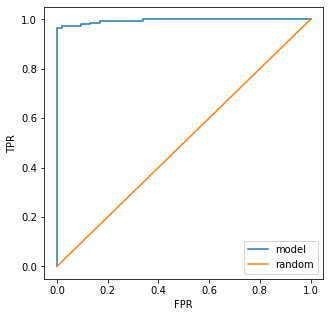

In [18]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='model')
plt.plot([0, 1], [0, 1], label='random')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

# ROC AUC

In [20]:
roc_auc_score(y_val, y_pred).round(3)

0.995

# Precision, Recall and F1

In [29]:
thresholds = np.arange(0.0, 1.01, 0.01)

In [34]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [56]:
scores = []

for t in thresholds:
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * ((precision * recall) / (precision + recall))
    
    scores.append((t, precision, recall, f1))


In [57]:
columns = ['threshold', 'precision', 'recall', 'f1']
df_scores = pd.DataFrame(scores, columns=columns)

Text(0.5, 0, 'Thresholds')

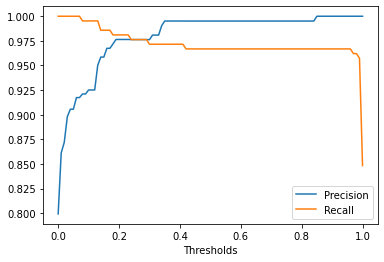

In [58]:
plt.plot(df_scores.threshold, df_scores.precision, label='Precision')
plt.plot(df_scores.threshold, df_scores.recall, label='Recall')
plt.legend()
plt.xlabel('Thresholds')

Text(0, 0.5, 'F1')

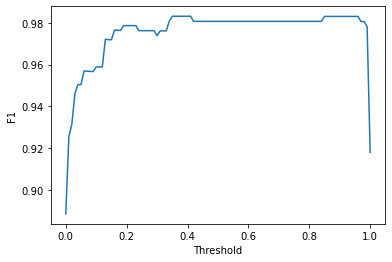

In [60]:
plt.plot(df_scores.threshold, df_scores.f1)
plt.xlabel('Threshold')
plt.ylabel('F1')

In [64]:
df_scores['f1'].max()

0.9832134292565947

In [73]:
df_scores[df_scores['f1'] == 0.9832134292565947].threshold.mean()

0.38

In [80]:
df_scores[df_scores['f1'] > 0.9832].T

,35,36,37,38,39,40,41
threshold,0.350000,0.360000,0.370000,0.380000,0.390000,0.400000,0.410000
precision,0.995146,0.995146,0.995146,0.995146,0.995146,0.995146,0.995146
recall,0.971564,0.971564,0.971564,0.971564,0.971564,0.971564,0.971564
f1,0.983213,0.983213,0.983213,0.983213,0.983213,0.983213,0.983213


# Cross-Validation

In [97]:
from sklearn.model_selection import KFold

In [98]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [99]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[numerical + categorical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [100]:
def predict(df, dv, model):
    dicts = df[numerical + categorical].to_dict(orient='records')
    
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    
    return y_pred

In [106]:
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    y_train = df_train.card.values
    y_val = df_val.card.values
    
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
    
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
np.std(scores).round(3)

0.003

In [102]:
from tqdm.auto import tqdm

In [110]:
for C in tqdm([0.01, 0.1, 1, 10]):
    
    scores = []
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
        
        y_train = df_train.card.values
        y_val = df_val.card.values
        
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    print("C=%s %.3f +- %.3f" % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/4 [00:00<?, ?it/s]

C=0.01 0.992 +- 0.006
C=0.1 0.995 +- 0.004
C=1 0.996 +- 0.003
C=10 0.996 +- 0.003
